#instagram

In [ ]:
from google.colab import drive
import os, json, csv, requests
from urllib.parse import urlparse
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def download_file(url, dest):
    r = requests.get(url, stream=True, timeout=10)
    r.raise_for_status()
    with open(dest, 'wb') as f:
        for chunk in r.iter_content(1024): f.write(chunk)

In [ ]:
def extract_metadata(in_path, out_csv):
    with open(in_path) as fin, open(out_csv, 'w', newline='') as fout:
        w = csv.writer(fout)
        w.writerow(['item_id','modality','image_urls','video_urls'])
        for line in fin:
            rec = json.loads(line)
            d = rec.get('data') or {}
            imgs = d.get('image_versions2',{}).get('candidates') or []
            if imgs:
                best = max(imgs, key=lambda c: c.get('width',0))
                iu = [best.get('url')]
            elif d.get('display_url'):
                iu = [d['display_url']]
            else:
                iu = []
            vids = d.get('video_versions') or []
            vu = [v.get('url') for v in vids if v.get('url')]
            mod = 'video' if vu else 'image' if iu else 'text' if d.get('caption') else 'unknown'
            w.writerow([rec.get('item_id'),mod,json.dumps(iu),json.dumps(vu)])

In [ ]:
def plot_modalities(csv_file):
    counts = Counter()
    with open(csv_file) as f:
        reader = csv.DictReader(f)
        for row in reader:
            counts[row['modality']] += 1
    plt.bar(counts.keys(), counts.values())
    plt.title('Content Modality Distribution')
    plt.xlabel('Modality')
    plt.ylabel('Count')
    plt.show()

In [ ]:
def download_images(csv_file, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    with open(csv_file) as f:
        reader = list(csv.DictReader(f))
    for idx, row in enumerate(tqdm(reader, desc='Downloading images')):
        if row['modality'] != 'image':
            continue
        urls = json.loads(row['image_urls'])
        for i, url in enumerate(urls):
            ext = os.path.splitext(urlparse(url).path)[1] or '.jpg'
            fn = f"{idx}_{row['item_id']}_{i}{ext}"
            path = os.path.join(out_dir, fn)
            if not os.path.exists(path):
                download_file(url, path)

In [ ]:
def main(ndjson, csv_out, drive_id):
    drive.mount('/content/drive')
    base = f"/content/drive/MyDrive/{drive_id}"
    os.makedirs(base, exist_ok=True)
    extract_metadata(ndjson, csv_out)
    plot_modalities(csv_out)
    download_images(csv_out, os.path.join(base, 'harris_additional_instagram_zeeschuimer'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


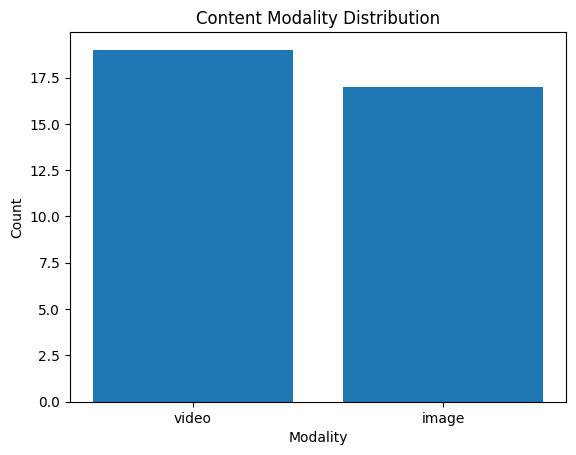

In [ ]:
NDJSON_FILE = '/content/drive/MyDrive/zeeschuimer-export-instagram.com-2025-05-27T201624.ndjson'
CSV_FILE    = '/content/drive/MyDrive/harris_additional_instagram_images_metadata.csv'
DRIVE_ID    = '1ZwCdyD0Psro0gGCa5wFsIeqJOBJJ0QGh'

main(NDJSON_FILE, CSV_FILE, DRIVE_ID)

# Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json, os, requests
from urllib.parse import urlparse
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
PARENT_FOLDER_ID   = '1ZwCdyD0Psro0gGCa5wFsIeqJOBJJ0QGh'
DOWNLOAD_ROOT    = f"/content/drive/MyDrive/{PARENT_FOLDER_ID}"
NDJSON_PATH        = '/content/drive/MyDrive/Silvia & Gayoung/trump_instagram_zeeschuimer.ndjson'
IMAGE_DIR        = os.path.join(DOWNLOAD_ROOT, 'trump_instagram_images')
VIDEO_DIR        = os.path.join(DOWNLOAD_ROOT, 'videos')


DOWNLOAD_IMAGES = True
download_videos = False

#setting
if DOWNLOAD_IMAGES:
    os.makedirs(IMAGE_DIR, exist_ok=True)
if download_videos:
    os.makedirs(VIDEO_DIR, exist_ok=True)

In [ ]:
def parse_posts(path):
    """Yield (post_id, img_urls, vid_urls, modality) from NDJSON."""
    with open(path, encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue
            data = obj.get('data') or {}
            # Pick only the highest-resolution image candidate
            imgs = data.get('image_versions2', {}).get('candidates', []) or []
            if imgs:
                # choose candidate with max width
                best = max(imgs, key=lambda c: c.get('width', 0))
                img_urls = [best.get('url')]
            elif data.get('display_url'):
                img_urls = [data['display_url']]
            else:
                img_urls = []
            # videos
            vids = data.get('video_versions', []) or []
            vid_urls = [v.get('url') for v in vids if v and v.get('url')]
            # modality
            if vid_urls:
                mod = 'video'
            elif img_urls:
                mod = 'image'
            elif data.get('caption'):
                mod = 'text'
            else:
                mod = 'unknown'
            yield obj.get('item_id'), img_urls, vid_urls, mod

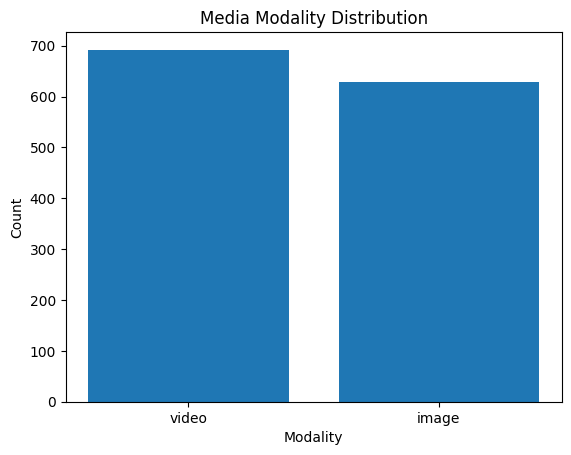

In [ ]:
records = list(parse_posts(NDJSON_PATH))
counts  = Counter(rec[3] for rec in records)

plt.figure()
plt.bar(counts.keys(), counts.values())
plt.title('Media Modality Distribution')
plt.xlabel('Modality')
plt.ylabel('Count')
plt.show()

In [ ]:
def download(url, dest):
    try:
        r = requests.get(url, stream=True, timeout=10)
        r.raise_for_status()
        with open(dest, 'wb') as f:
            for chunk in r.iter_content(1024): f.write(chunk)
    except Exception as e:
        print(f"Failed to download {url}: {e}")

In [ ]:
for post_id, img_urls, vid_urls, _ in tqdm(records, desc='Downloading media'):
    if DOWNLOAD_IMAGES and img_urls:
        for idx, url in enumerate(img_urls):
            ext = os.path.splitext(urlparse(url).path)[1] or '.jpg'
            fname = f"{post_id}_img_{idx}{ext}"
            out   = os.path.join(IMAGE_DIR, fname)
            if not os.path.isfile(out):
                download(url, out)
    if download_videos and vid_urls:
        for idx, url in enumerate(vid_urls):
            ext = os.path.splitext(urlparse(url).path)[1] or '.mp4'
            fname = f"{post_id}_vid_{idx}{ext}"
            out   = os.path.join(VIDEO_DIR, fname)
            if not os.path.isfile(out):
                download(url, out)

print("Download completed")

KeyboardInterrupt: 